In [28]:
### Creating an in-memory SQLite database and loading the data in order to recreate the transformations in the sql files
### Then performing basic descriptive analysis on the data

from sqlalchemy import create_engine, text
import pandas as pd

# Step 1: Load the data
data = pd.read_csv('analytics_engineering_task.csv')

# Step 2: Create an in-memory SQLite database
engine = create_engine('sqlite:///:memory:')
connection = engine.connect()

# Load the CSV data into a SQL table called 'staging_events'
data.to_sql('staging_events', con=engine, index=False, if_exists='replace')

# Step 3: Define and execute the first transformation (trial_goals)
sql_trials_query = text("""
WITH trial_goals AS (
    SELECT 
        organization_id,
        -- goal 1: at least 2 shifts created
        CASE WHEN SUM(CASE WHEN activity_name = 'Shift.Created' THEN 1 ELSE 0 END) >= 2 THEN 1 ELSE 0 END AS shift_created,
        
        -- goal 2: at least 1 employee invited
        CASE WHEN SUM(CASE WHEN activity_name = 'Employee.Invited' THEN 1 ELSE 0 END) >= 1 THEN 1 ELSE 0 END AS employee_invited,
        
        -- goal 3: at least 1 punch-in
        CASE WHEN SUM(CASE WHEN activity_name = 'Punch.In' THEN 1 ELSE 0 END) >= 1 THEN 1 ELSE 0 END AS punch_in,
        
        -- goal 4: at least 1 punch-in approved
        CASE WHEN SUM(CASE WHEN activity_name = 'Punch.In.Approved' THEN 1 ELSE 0 END) >= 1 THEN 1 ELSE 0 END AS punch_in_approved,
        
        -- goal 5: at least 2 advanced features viewed
        CASE WHEN SUM(CASE WHEN activity_name = 'Page.Viewed' AND activity_detail IN ('revenue-overview', 'integrations-overview', 'absence-overview', 'availability-overview') THEN 1 ELSE 0 END) >= 2 THEN 1 ELSE 0 END AS advanced_features_viewed
    FROM staging_events
    GROUP BY organization_id
)
SELECT * FROM trial_goals
""")

# Execute the first query and store the result
df_trials = pd.read_sql_query(sql_trials_query, connection)

# Step 4: Define the second query that references the trial_goals transformation
sql_goals_query = text("""
WITH trial_goals AS (
    SELECT * FROM (
        SELECT 
            organization_id,
            CASE WHEN SUM(CASE WHEN activity_name = 'Shift.Created' THEN 1 ELSE 0 END) >= 2 THEN 1 ELSE 0 END AS shift_created,
            CASE WHEN SUM(CASE WHEN activity_name = 'Employee.Invited' THEN 1 ELSE 0 END) >= 1 THEN 1 ELSE 0 END AS employee_invited,
            CASE WHEN SUM(CASE WHEN activity_name = 'Punch.In' THEN 1 ELSE 0 END) >= 1 THEN 1 ELSE 0 END AS punch_in,
            CASE WHEN SUM(CASE WHEN activity_name = 'Punch.In.Approved' THEN 1 ELSE 0 END) >= 1 THEN 1 ELSE 0 END AS punch_in_approved,
            CASE WHEN SUM(CASE WHEN activity_name = 'Page.Viewed' AND activity_detail IN ('revenue-overview', 'integrations-overview', 'absence-overview', 'availability-overview') THEN 1 ELSE 0 END) >= 2 THEN 1 ELSE 0 END AS advanced_features_viewed
        FROM staging_events
        GROUP BY organization_id
    )
)
SELECT
    organization_id,
    CASE 
        WHEN shift_created = 1 THEN 'shift_created'
        WHEN employee_invited = 1 THEN 'employee_invited'
        WHEN punch_in = 1 THEN 'punch_in'
        WHEN punch_in_approved = 1 THEN 'punch_in_approved'
        WHEN advanced_features_viewed = 1 THEN 'advanced_features_viewed'
    END AS trial_activation
FROM trial_goals
""")

# Execute the second query
df_goals = pd.read_sql_query(sql_goals_query, connection)

# Step 5: Display the result
print(df_goals)

# Close the connection
connection.close()


                      organization_id trial_activation
0    0021ac0e558f8f7047388e7523afd327             None
1    0036e85dfef040accb2c0bbb0ff43fda             None
2    0040dd9ab132b92d5d04bc3acf14d2e2    shift_created
3    00456fd86311b6095ad05f7e31758f0d             None
4    0059a7e6d21805f9ebc6d58b5aa6042f    shift_created
..                                ...              ...
926  48d7c381ede883bfd6dfeeb78a9f0e51    shift_created
927  48f094fd67ff1c3c93274432dc37810d    shift_created
928  48f1931ef3f3b3439b1091a83e2a1bf5    shift_created
929  4901a4efd238312a93a28cf9ec462eae             None
930  4914791cbad9bfc77471afef44a9c928    shift_created

[931 rows x 2 columns]


In [29]:
df_goals.head()


,organization_id,trial_activation
0,0021ac0e558f8f7047388e7523afd327,None
1,0036e85dfef040accb2c0bbb0ff43fda,None
2,0040dd9ab132b92d5d04bc3acf14d2e2,shift_created
3,00456fd86311b6095ad05f7e31758f0d,None
4,0059a7e6d21805f9ebc6d58b5aa6042f,shift_created


In [30]:
# Basic Descriptive Analysis for Product Metrics

# 1. Total number of organizations
total_organizations = df_goals['organization_id'].nunique()

# 2. Number of organizations that achieved trial activation (i.e., completed at least one trial goal)
trial_activation_counts = df_goals['trial_activation'].value_counts()

# 3. Trial Activation Rate (percentage of organizations that completed any goal)
activated_organizations = len(df_goals[df_goals['trial_activation'].notnull()])
activation_rate = (activated_organizations / total_organizations) * 100

# 4. Completion Rate for each goal (e.g., 'shift_created', 'employee_invited', etc.)
completion_rates = df_goals['trial_activation'].value_counts(normalize=True) * 100

# 5. Drop-off Points: Analyze where most organizations fail
# Here we consider organizations that did not complete certain goals
drop_off_points = df_goals['trial_activation'].isnull().sum()

# 6. Display the basic metrics
print(f"Total Organizations: {total_organizations}")
print(f"Activated Organizations: {activated_organizations}")
print(f"Activation Rate: {activation_rate:.2f}%")

print("\nCompletion Rates per Goal:")
print(completion_rates)

print(f"\nNumber of Organizations that Failed to Complete Any Goal: {drop_off_points}")


Total Organizations: 931
Activated Organizations: 628
Activation Rate: 67.45%

Completion Rates per Goal:
shift_created               98.248408
advanced_features_viewed     1.751592
Name: trial_activation, dtype: float64

Number of Organizations that Failed to Complete Any Goal: 303


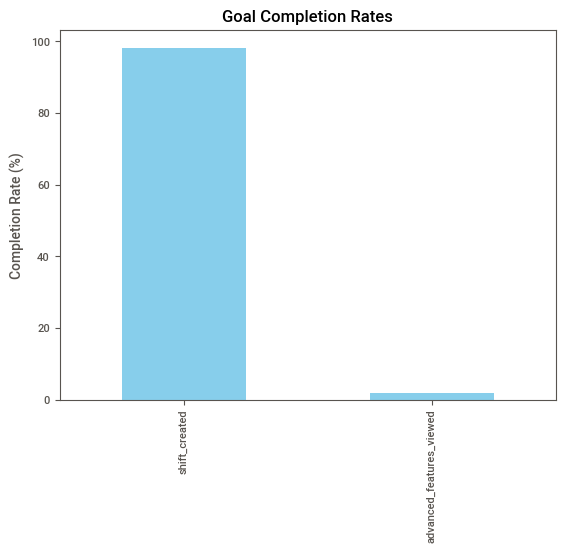

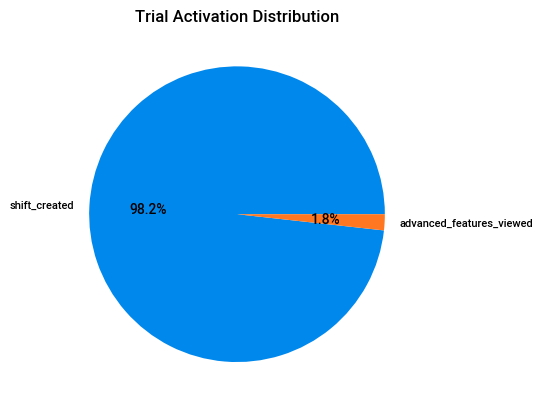

In [33]:
import matplotlib.pyplot as plt

# Plot completion rates for each goal
completion_rates.plot(kind='bar', title='Goal Completion Rates', color='skyblue')
plt.ylabel('Completion Rate (%)')
plt.show()

# Pie chart for trial activation distribution
trial_activation_counts.plot(kind='pie', autopct='%1.1f%%', title='Trial Activation Distribution')
plt.ylabel('')
plt.show()
